In [1]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Quantum state teleportation

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

This tutorial introduces **Quantum State Teleportation**, a fundamental protocol in quantum information science. We will cover the theoretical foundations and motivations behind quantum teleportation, examine its mathematical formulation, and implement it using **QuAIRKit**.

**Table of Contents**

- [Introduction](#introduction)
  - [Background](#background)  
  - [Motivation](#motivation)  
- [Single Qubit Teleportation](#single-qubit-teleportation)
  - [Mathematical Proof](#mathematical-proof-of-teleportation)
  - [QuAIRKit Implementation](#quairkit-implementation)
- [Summary](#summary)

In [2]:
import torch
import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.operator import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

## Introduction

### Background

Quantum state teleportation is a process whereby the quantum information of a particle is transferred from one location (the sender, "Alice") to another (the receiver, "Bob"), without physically transmitting the particle itself[1]. First proposed by Bennett *et al.* in 1993[2], this protocol has become a cornerstone of quantum information science. Unlike classical information transfer, quantum teleportation transmits the complete quantum state while the original state is necessarily destroyed in the process.

The quantum teleportation protocol relies on several essential components that work together to transfer quantum states.

The quantum circuit shown below provides a schematic representation of the quantum teleportation protocol[1].

<figure style="text-align: center;">
  <img src="figures/teleportation_circuit.png" alt="alt text"/>
  <figcaption>Quantum Teleportation Circuit. </figcaption>
</figure>

In this circuit, the two upper lines represent Alice's system, while the bottom line represents Bob's system. The meters denote measurements, and the double lines represent classical communication channels carrying classical bits (recall that single lines denote qubits).

First, **entanglement** is established between two quantum systems (for example, qubits) by preparing them in a maximally entangled Bell state, such as
$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \, (|00\rangle + |11\rangle).\tag{1}
$$
This is one of the four Bell states, with the other three being:
$$
\begin{align}
|\Phi^-\rangle &= \frac{1}{\sqrt{2}} \, (|00\rangle - |11\rangle)\tag{2}\\
|\Psi^+\rangle &= \frac{1}{\sqrt{2}} \, (|01\rangle + |10\rangle)\tag{3}\\
|\Psi^-\rangle &= \frac{1}{\sqrt{2}} \, (|01\rangle - |10\rangle)\tag{4}
\end{align}
$$
This shared entangled pair is distributed between Alice and Bob, creating a quantum channel that connects them. Next, Alice takes the unknown quantum state she wants to teleport, namely
$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle,\tag{5}
$$
and performs a **Bell-state measurement (BSM)** on this state combined with her half of the entangled pair. A BSM is a joint measurement that projects two qubits onto one of the four maximally entangled Bell states defined above. This measurement essentially "compares" the unknown state with Alice's entangled qubit, encoding their relationship into a two-bit classical result (00, 01, 10, or 11 corresponding to which Bell state was measured). Although the outcome is random, it encodes the precise transformation that Bob needs to apply to recover the original state.
After the measurement, Alice sends the two classical bits—which represent her measurement result—to Bob via a classical communication channel. Finally, Bob uses these bits to perform a conditional unitary transformation (which might be the identity, a bit-flip $X$, a phase-flip $Z$, or both $XZ$) on his half of the entangled pair. This corrects the state of Bob's qubit, reconstructing exactly the state $|\psi\rangle$ that Alice intended to send.
In summary, the protocol involves:
- **Pre-sharing entanglement:** Alice and Bob share a Bell state.
- **Measurement and Communication:** Alice performs a Bell measurement on her unknown qubit $|\psi\rangle$ and her entangled qubit, then sends the two classical bits (the measurement outcome) to Bob.
- **State Reconstruction:** Bob applies the corresponding unitary operation to his qubit so that it assumes the state $|\psi\rangle$.

### Motivation

Quantum teleportation serves as both a cornerstone for practical implementations—such as long-distance quantum communication and distributed quantum computing—and as an indispensable theoretical tool for simplifying and characterizing complex adaptive protocols. By exploiting entanglement and classical communication, teleportation enables the mapping of arbitrary quantum channels into simplified forms, facilitating the analysis of quantum communication protocols.

Beyond communication, quantum teleportation has become a foundational resource in quantum metrology, channel discrimination, and resource theories of quantum processors. The protocol not only facilitates operational tasks but also provides deep insight into diverse physical phenomena, from quantum catalysis and decoherence to direct wavefunction measurement and macroscopic quantum effects, thereby highlighting its dual role as both a practical protocol and a lens through which the subtleties of quantum mechanics can be explored.

## Single Qubit Teleportation

### Mathematical Proof of Teleportation
In this section, we provide a detailed mathematical derivation of the quantum teleportation protocol. We demonstrate step-by-step how an unknown single-qubit state can be transmitted from Alice to Bob using one Bell pair and two classical bits. 

Our task is to teleport an **unknown** single-qubit state  
$$
|\psi\rangle = \alpha\,|0\rangle + \beta\,|1\rangle,\tag{6}
$$  
with $\alpha,\beta\in\mathbb{C}$ and $|\alpha|^2 + |\beta|^2 = 1$.

1. **Initial state**  
   Alice holds $|\psi\rangle$ (qubit 0) and one half of a Bell pair; Bob holds the other half (qubit 2). The total three-qubit state is  
   $$
   |\psi_0\rangle
   = |\psi\rangle \,\bigl|\beta_{00}\bigr\rangle
   = \frac{1}{\sqrt 2}\bigl[\alpha\,|0\rangle(|00\rangle+|11\rangle)
   + \beta\,|1\rangle(|00\rangle+|11\rangle)\bigr].\tag{7}
   $$


2. **Apply CNOT** (control = qubit 0, target = qubit 1):  
   $$
   |\psi_1\rangle
   = \frac{1}{\sqrt 2}\bigl[\alpha\,|0\rangle(|00\rangle+|11\rangle)
   + \beta\,|1\rangle(|10\rangle+|01\rangle)\bigr].\tag{8}
   $$

3. **Apply Hadamard** on qubit 0:  
   $$
   |\psi_2\rangle
   = \frac{1}{2}\Bigl[\alpha\,(|0\rangle+ |1\rangle)(|00\rangle+|11\rangle)
   + \beta\,(|0\rangle- |1\rangle)(|10\rangle+|01\rangle)\Bigr].\tag{9}
   $$  

   Expand and regroup:
   $$
   \begin{aligned}
   |\psi_2\rangle = \tfrac12\Bigl[\, &|00\rangle(\alpha|0\rangle+\beta|1\rangle)
   +|01\rangle(\alpha|1\rangle+\beta|0\rangle)\\
   +&|10\rangle(\alpha|0\rangle-\beta|1\rangle)
   +|11\rangle(\alpha|1\rangle-\beta|0\rangle)\Bigr].
   \end{aligned}
   $$

4. **Bell-state measurement**  
   Alice uses bell bases measures her two qubits, and gets the measurement outcomes (00, 01, 10, 11). Conditional on the outcome $m_1m_2$, Bob's qubit collapses to  
   $$
   \begin{aligned}
   00 &\longmapsto\;[\alpha|0\rangle+\beta|1\rangle],\\
   01 &\longmapsto\;[\alpha|1\rangle+\beta|0\rangle] = X\,|\psi\rangle,\\
   10 &\longmapsto\;[\alpha|0\rangle-\beta|1\rangle] = Z\,|\psi\rangle,\\
   11 &\longmapsto\;[\alpha|1\rangle-\beta|0\rangle] = XZ\,|\psi\rangle.
   \end{aligned}
   $$

5. **Classical communication**: Alice sends $(m_1,m_2)$ to Bob.  
6. **Reconstruction** : Bob applies $Z^{m_1}X^{m_2}$ to recover  
   $$
   Z^{m_1}X^{m_2}\bigl[\dots\bigl] = \alpha|0\rangle+\beta|1\rangle = |\psi\rangle.\tag{10}
   $$

This completes the proof that an *unknown* qubit state can be faithfully transmitted using one Bell pair and two classical bits.

### QuAIRKit Implementation

Below is a step-by-step QuAIRKit implementation that mirrors the above mathematical proof.

We begin by creating a random quantum state and combining it with a Bell state to prepare the input state. In this example, we choose a batch size of 100 for the input states.

In [3]:
psi = random_state(1, size=100)
input_state = nkron(psi, bell_state(2))

Next, we prepare the one-way LOCC controlled gates on Bob's side: an identity stack combined with X and Z gates.

In [4]:
M1_locc = torch.stack([eye(), x()])
M2_locc = torch.stack([eye(), z()])

With the gate stacks ready, we construct the 3‑qubit circuit. We apply CNOT and Hadamard gates at the appropriate positions, then use the `locc` function to associate the stacked gates with measurement results and target qubits.

The usage of `Circuit.locc` is as follows:

- **First argument**: A stack of operators, i.e., a list of quantum operations (such as gates or measurements) that will be applied in sequence on the circuit.

- **Second argument**: Two arrays of integer indices  
  - The first array specifies which qubit positions serve as control qubits.  
  - The second array specifies which qubit positions serve as target (or "controlled") qubits.

- **Third argument**:  
  - `label=` gives a name to the measurement.  
  - `latex_name=` specifies name of the controlled gate.

For example, consider a set of measurement operators $\{\mathcal{M}_x\}$. Conditioned on the outcome $x$, one applies the operator $\mathcal{N}^{(x)}$. The overall quantum channel can then be expressed as

$$
\mathcal{N} = \sum_x \mathcal{M}_x \otimes \mathcal{N}^{(x)},\tag{11}
$$

where each $\mathcal{N}^{(x)}$ is a CPTP map acting on the appropriate subsystem, and $\sum_x \mathcal{M}_x$ is itself a CPTP map on the measured subsystem. In order to implement this in `Circuit.locc`, one stacks all of the operators $\mathcal{N}^{(x)}$ (in ascending order of $x$) as the first argument; uses `label=` to name the measurement $\mathcal{M}_x$; and specifies the name $N^{(x)}$ in `latex_name=`.

In [5]:
cir = Circuit(3)
cir.cnot([0, 1])
cir.h(0)

cir.locc(M1_locc, [1, 2], label='M_2', latex_name='X')
cir.locc(M2_locc, [0, 2], label='M_1', latex_name='Z')

We can visualize the circuit as follows:

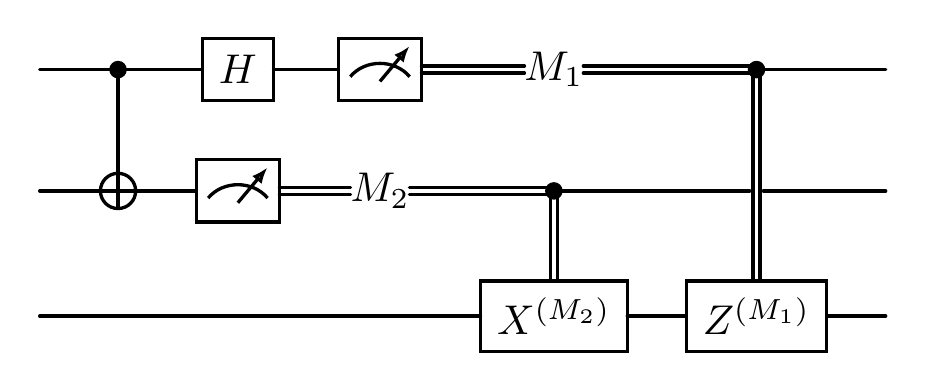

In [6]:
cir.plot()

After running the teleportation circuit, there are 4 measurement branches per input state (one for each combination of Alice's two classical bits), so we have 100 × 4 = 400 output states.

In [7]:
output_state = cir(input_state).trace([0, 1])

We then use the `expec_state` attribute to collapse those 400 conditioned states back into a batch of 100 "expected" states.

Finally, we compare the teleported state with the original state by computing the minimum fidelity across the four possible measurement outcomes.

In [8]:
result = state_fidelity(output_state.expec_state(), psi)
print("The average fidelity of the qubit teleportation protocol on all outcomes and 100 random states is:", result.mean().item())

The average fidelity of the qubit teleportation protocol on all outcomes and 100 random states is: 1.0000000032976404


## Summary

This tutorial demonstrated quantum teleportation through mathematical proof and practical implementation. We showed how an unknown quantum state can be transmitted using one Bell pair and two classical bits, with the key insight being that entanglement enables the transfer of quantum information without physically moving the qubit itself. The QuAIRKit implementation validated this protocol by successfully teleporting random quantum states with high fidelity.

---

## References

[1] Nielsen, Michael A., and Isaac L. Chuang. Quantum computation and quantum information. Cambridge university press, 2010.

[2] Bennett, Charles H., et al. "Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels." Physical review letters 70.13 (1993): 1895.

*Table: A reference of notation conventions in this tutorial.*

| Symbol                                      | Description                                                                                     |
|:--------------------------------------------:|:---------------------------------------------------------------|
| $\ket{\Phi^+}$        | A maximally entangled Bell state: $\tfrac1{\sqrt2}(\ket{00} + \ket{11})$                       |
| $\ket{\psi}$          | The unknown quantum state to be teleported                                                      |
| $\alpha, \beta$       | Complex amplitudes of the quantum state                                                         |
| $X, Y, Z$             | Pauli matrices                                                                  |
| $\mathcal{M}_x$       | Measurement operator                                                            |
| $m_1, m_2$            | Alice's measurement outcomes (classical bits)                                                   |
| $\rho$                | Density matrix of a quantum state                                                              |

In [9]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
